In [132]:
import os

Load filenames

In [177]:
train_path = "../../dataset/brain/singlecoil_train/"
val_path = "../../dataset/brain/singlecoil_val/"

with os.scandir(train_path) as entries:
    train_list = [train_path + entry.name for entry in entries if entry.is_file()]

with os.scandir(val_path) as entries:
    val_list = [val_path + entry.name for entry in entries if entry.is_file()]

print(len(train_list))
print(len(val_list))


2
2


imports

In [184]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

In [185]:
def summarize_mri_data(file_paths):
    """
    Summarizes MRI data files by reporting common dataset shapes, data types,
    and the presence of certain keys across a collection of HDF5 files.
    
    Parameters:
    file_paths (list of str): List of paths to the HDF5 files.
    
    Returns:
    A summary of the datasets across all files.
    """
    data_summary = defaultdict(lambda: defaultdict(list))

    for file_path in file_paths:
        with h5py.File(file_path, 'r') as hf:
            for key in ['kspace', 'reconstruction_esc', 'reconstruction_rss']:
                data = hf[key]
                data_summary[key]['shapes'].append(data.shape)
                data_summary[key]['types'].append(data.dtype)

            # Extract ISMRMRD header information if necessary
            if 'ismrmrd_header' in hf:
                header = str(hf['ismrmrd_header'][()])
                # Additional parsing of the header can be done here if specific info is required
            
    # Summarize data across files
    for key, info in data_summary.items():
        shapes = np.array(info['shapes'], dtype=object)
        unique_shapes = {tuple(shape) for shape in shapes}
        data_types = Counter(info['types'])

        print(f"\nSummary for {key}:")
        print(f"  Unique Shapes: {unique_shapes}")
        print(f"  Data Types: {data_types}")
        print(f"  Number of files: {len(shapes)}")
        if shapes.size > 0:
            print(f"  Average Dimensions: {np.mean(shapes, axis=0)}")
summarize_mri_data(train_list)


Summary for kspace:
  Unique Shapes: {(14, 640, 320), (16, 640, 320)}
  Data Types: Counter({dtype('complex128'): 2})
  Number of files: 2
  Average Dimensions: [15.0 640.0 320.0]

Summary for reconstruction_esc:
  Unique Shapes: {(14, 640, 320), (16, 640, 320)}
  Data Types: Counter({dtype('complex128'): 2})
  Number of files: 2
  Average Dimensions: [15.0 640.0 320.0]

Summary for reconstruction_rss:
  Unique Shapes: {(14, 320, 320), (16, 320, 320)}
  Data Types: Counter({dtype('<f4'): 2})
  Number of files: 2
  Average Dimensions: [15.0 320.0 320.0]


Opening one of the 5p file, keys are: <KeysViewHDF5 ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']>

In [172]:

hf = h5py.File(train_list[0], 'r')
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']
Attrs: {}
(16, 320, 320)
(16, 640, 320)


Function to display a number of slices at once

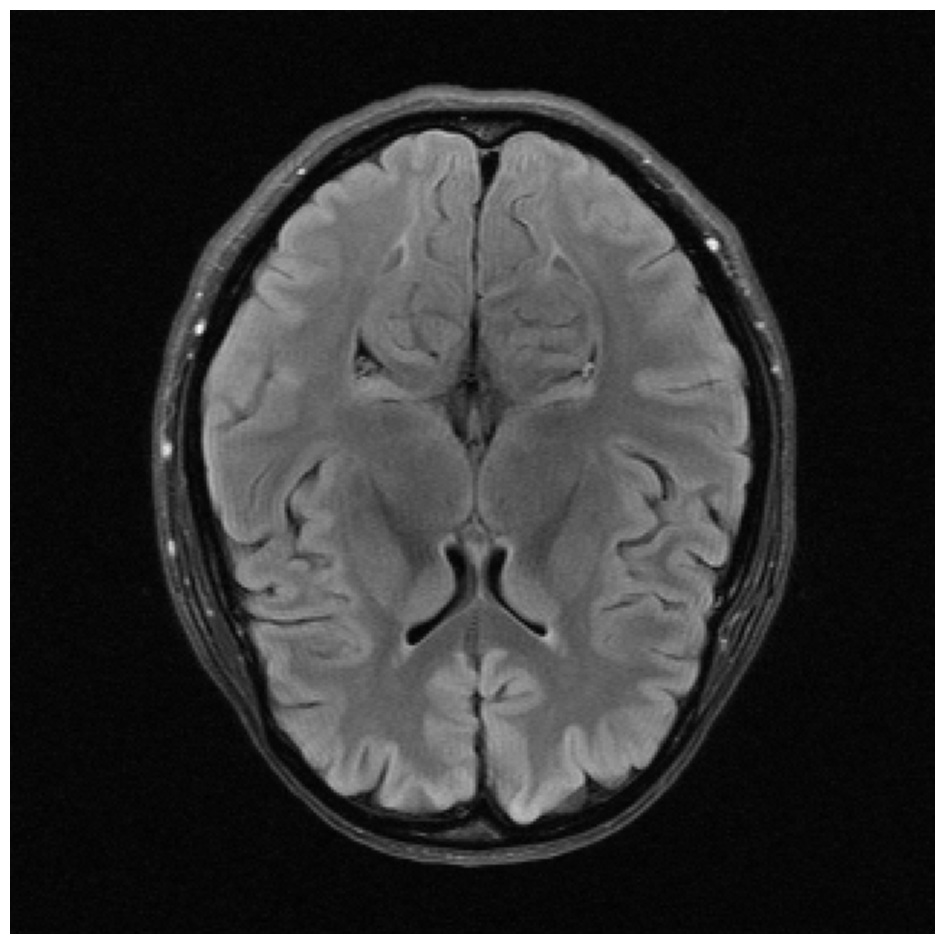

In [174]:
def show_slices(data, slices, cmap='gray', size=24):
    fig = plt.figure(figsize=(size,size/2))
    for i, num in enumerate(slices):
        plt.subplot(1, len(slices), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.axis('off')

Show kspace

(16, 640, 320)


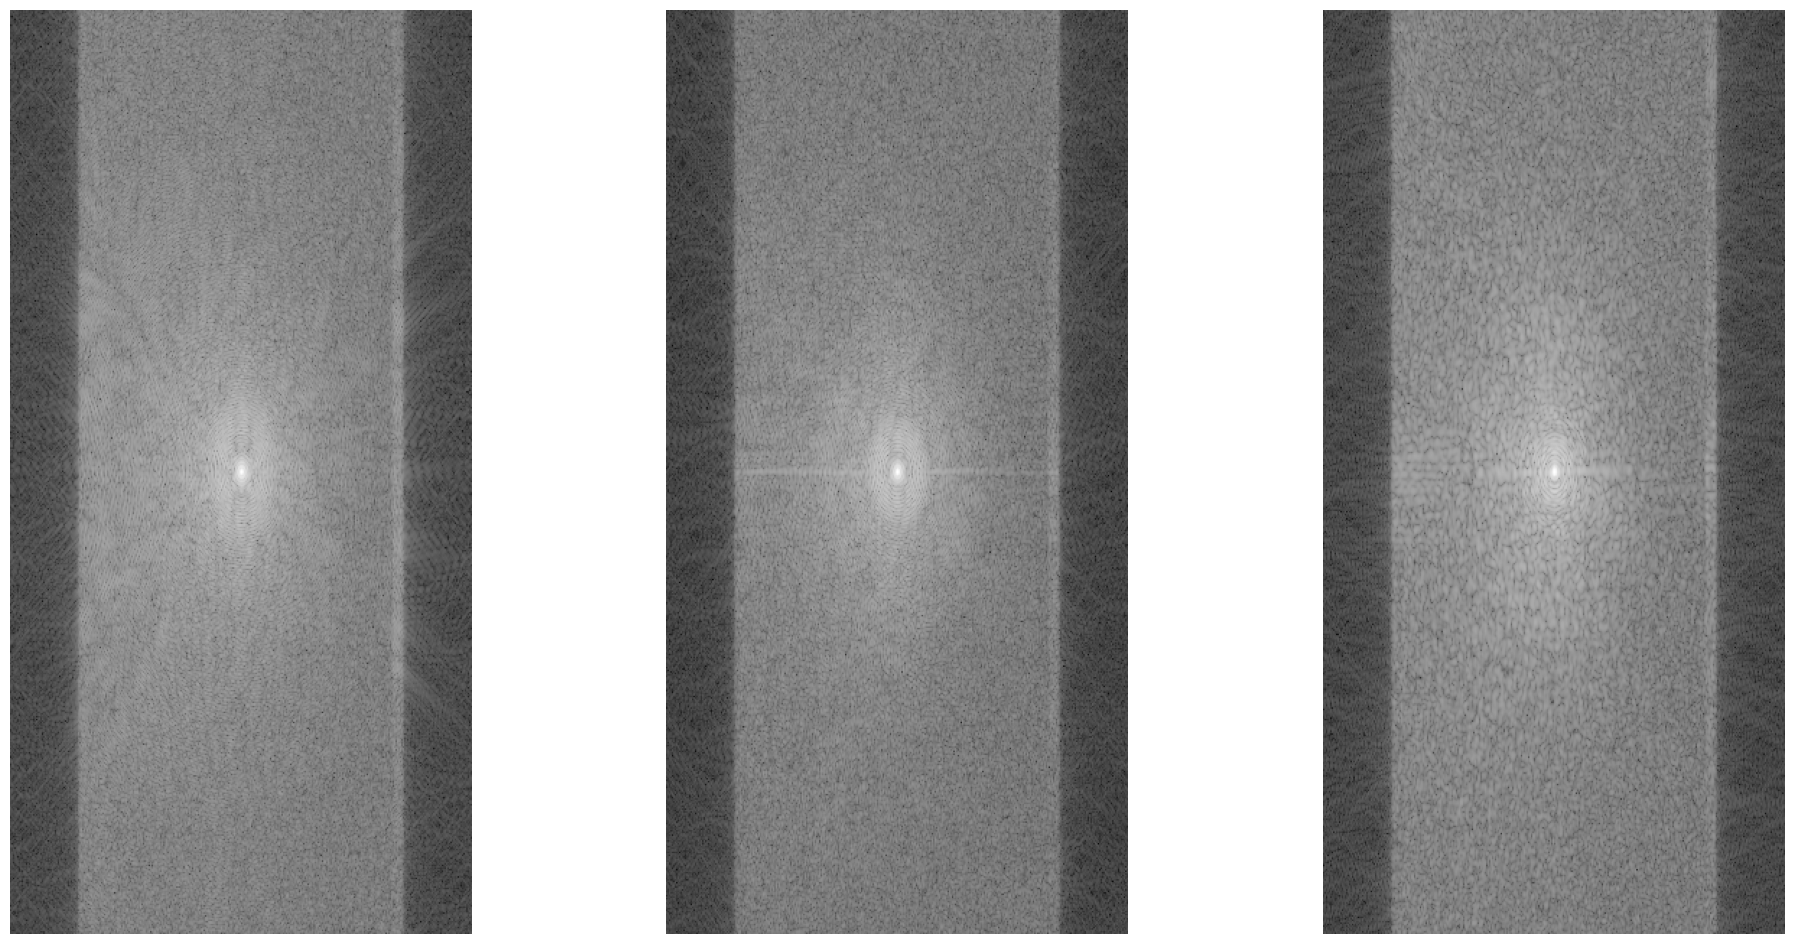

In [137]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.shape)

show_slices(np.log(np.abs(volume_kspace) + 1e-9), [0, 5, 10])  # This shows slices 0, 5 and 10, convert complex to real number with log of abs

Show 1 image

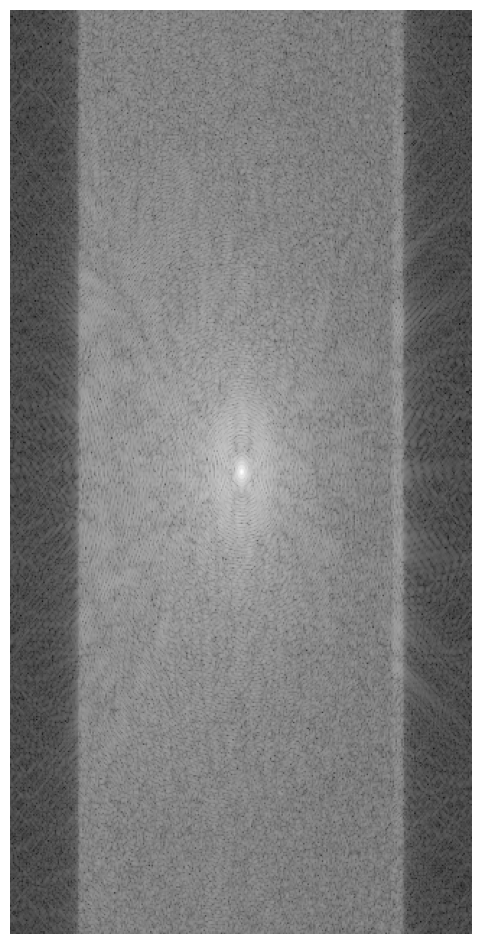

In [145]:
show_slices(np.log(np.abs(volume_kspace) + 1e-9), [0])  # This shows slices 0, 5 and 10, convert complex to real number with log of abs

In [139]:
import fastmri
from fastmri.data import transforms as T

Convert to image

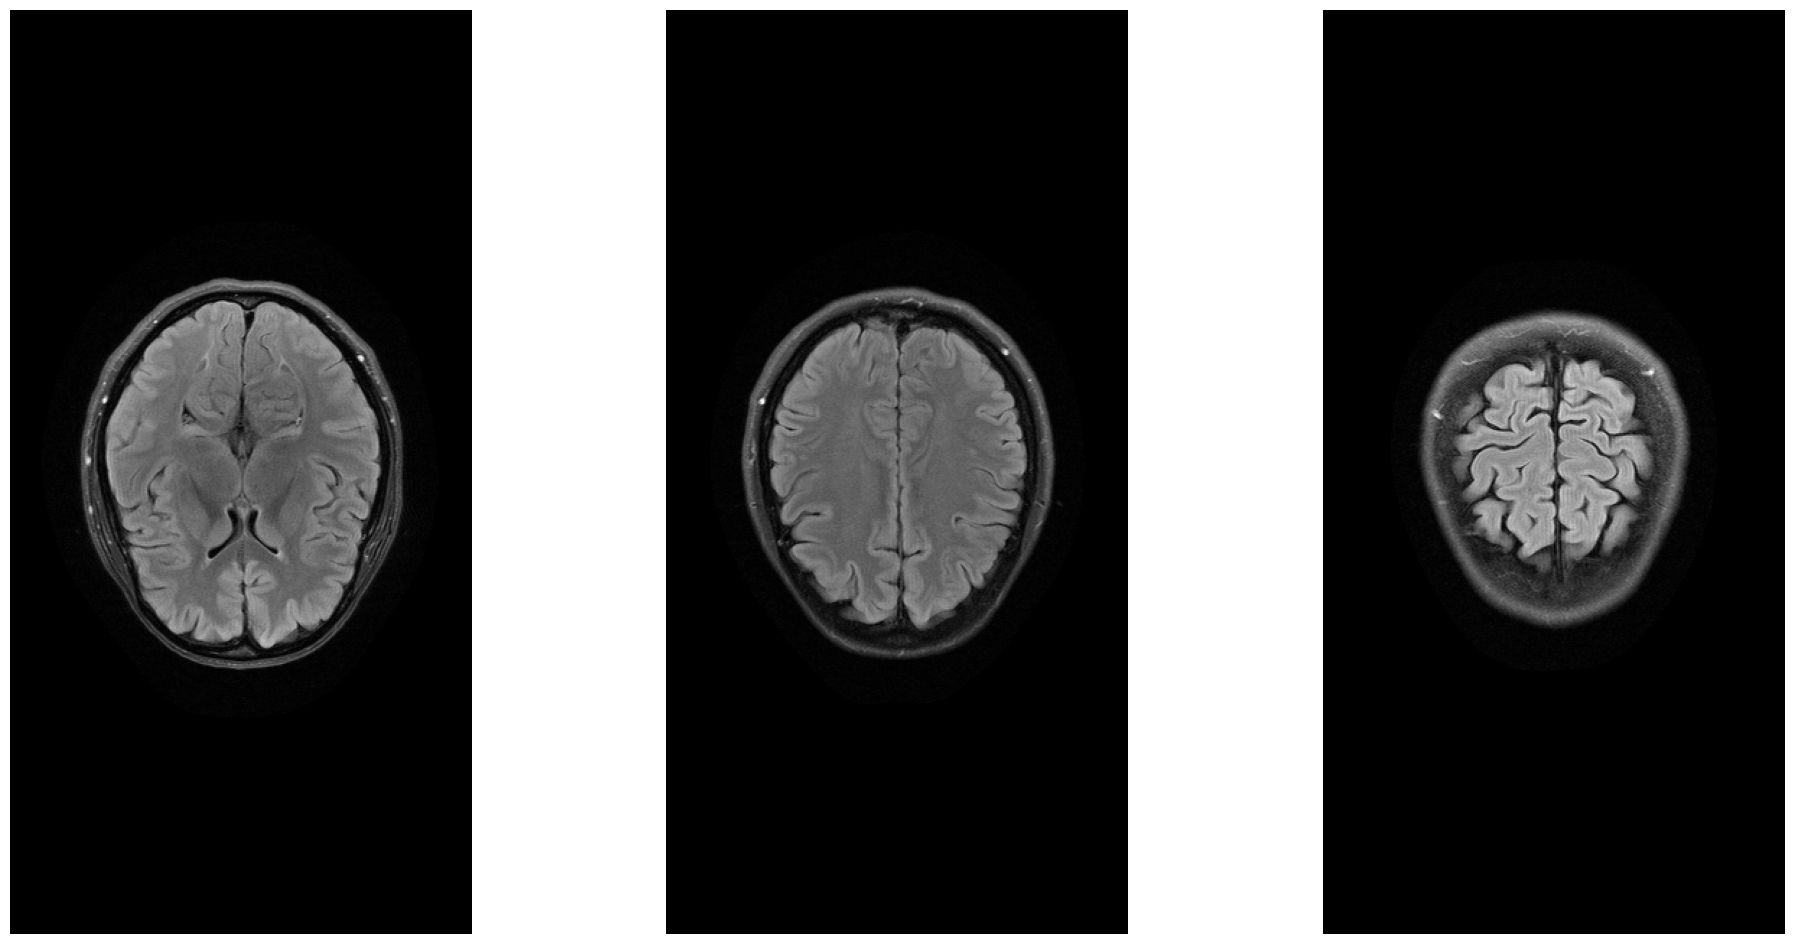

In [146]:
vol_kspace2 = T.to_tensor(volume_kspace)      # Convert from numpy array to pytorch tensor
vol_image = fastmri.ifft2c(vol_kspace2)           # Apply Inverse Fourier Transform to get the complex image
vol_image_abs = fastmri.complex_abs(vol_image)   # Compute absolute value to get a real image

show_slices(vol_image_abs, [0, 5, 10], cmap='gray')

Now we want to undersample the data

In [141]:
from fastmri.data.subsample import RandomMaskFunc

mask_func = RandomMaskFunc(center_fractions=[0.1], accelerations=[8])
masked_kspace, mask, _ = T.apply_mask(vol_kspace2, mask_func)

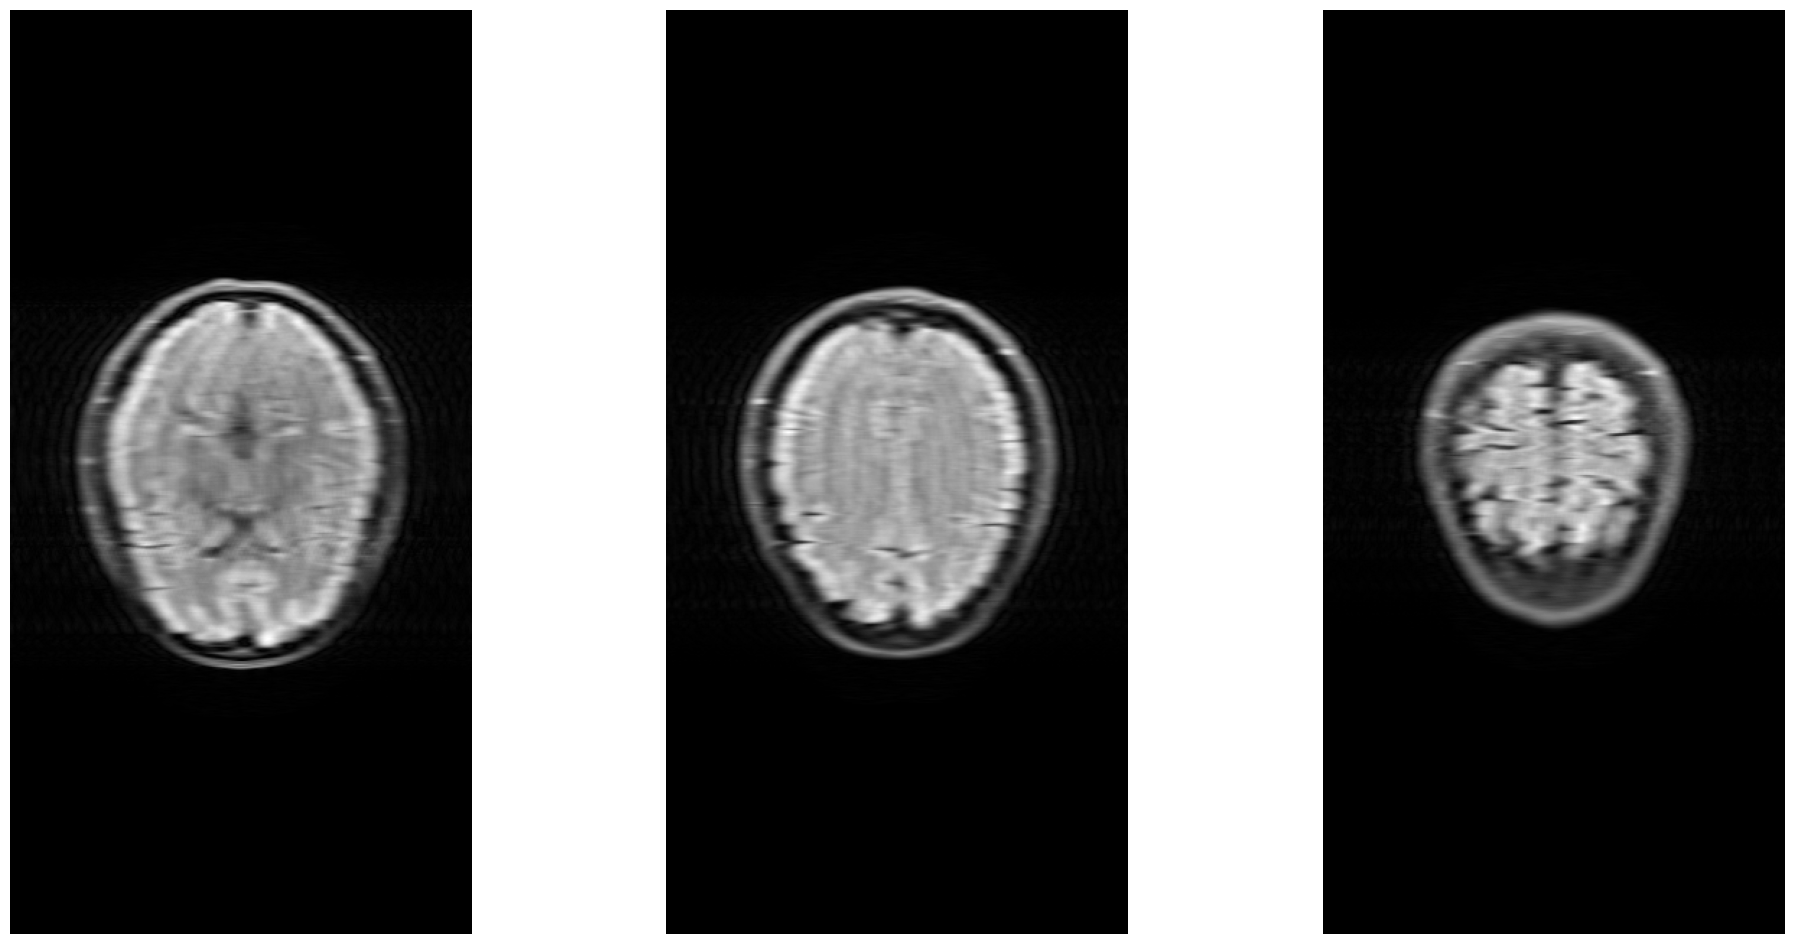

In [155]:
vol_image_undersampled = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
vol_image_abs_undersampled = fastmri.complex_abs(vol_image_undersampled)   # Compute absolute value to get a real image

show_slices(vol_image_abs_undersampled, [0, 5, 10], cmap='gray')

Display images in maximal resolution

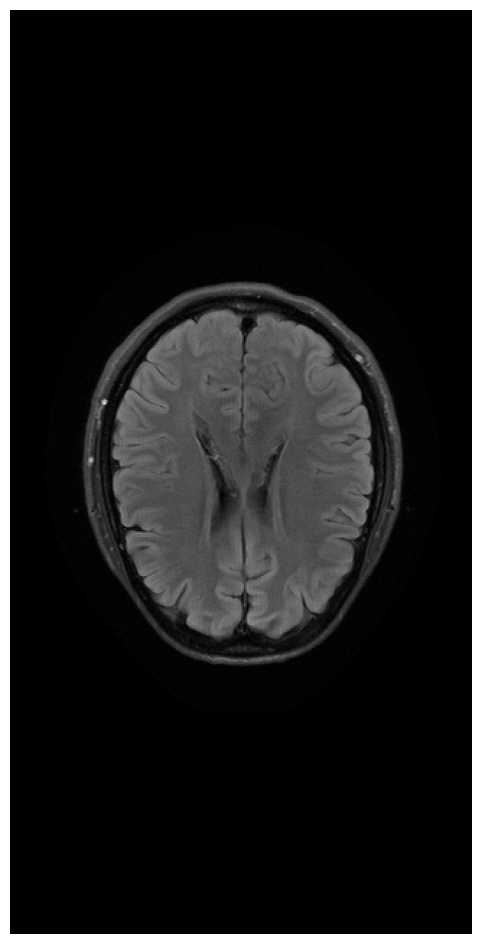

In [161]:
show_slices(vol_image_abs, [3])

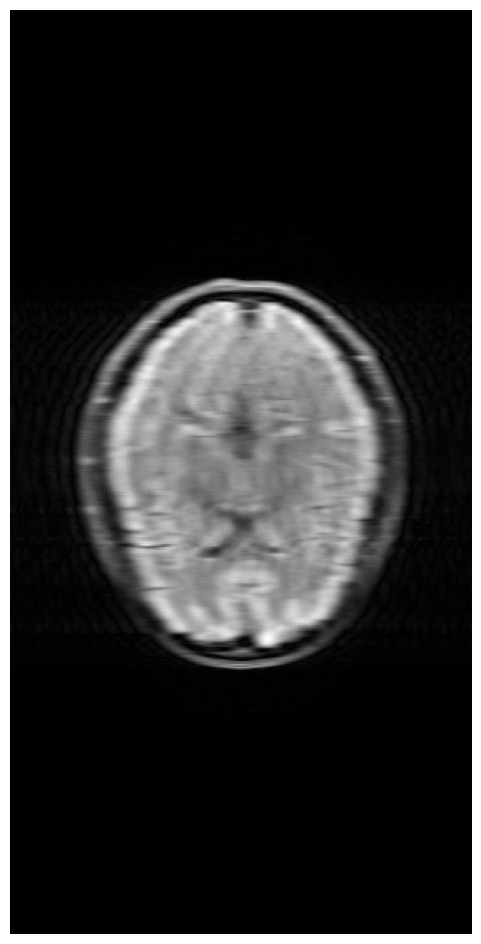

In [153]:
show_slices(vol_image_abs_undersampled, [0])